### This notebook compares performance of the custom-trained YOLOv5 small model on thermal images to the default YOLOv5 medium model, which was trained on visible images

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import ast, os
import matplotlib
import numpy as np

matplotlib.rcParams.update({'font.size': 14})

In [2]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

### Read in image directory dataframes

In [3]:
# Medium thermal model
med_therm_path = '/Users/josephking/Documents/sponsored_projects/MERGEN/data/pix2pix/MERGEN/test_/Bboxes_medium_thermal.csv'
med_therm = pd.read_csv(med_therm_path, usecols=['Make', 'Model', 'Source Path', 'Bboxes'])
med_therm['Bboxes'] = med_therm['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))

# Medium visible model
med_vis_path = '/Users/josephking/Documents/sponsored_projects/MERGEN/data/pix2pix/MERGEN/test_/Bboxes_medium_visible.csv'
med_vis = pd.read_csv(med_vis_path, usecols=['Make', 'Model', 'Source Path', 'Bboxes'])
med_vis['Bboxes'] = med_vis['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))

# Small thermal model
sm_therm_path = '/Users/josephking/Documents/sponsored_projects/MERGEN/data/pix2pix/MERGEN/test_/Bboxes_yolov5_thermal.csv'
sm_therm = pd.read_csv(sm_therm_path, usecols=['Make', 'Model', 'Source Path', 'Bboxes'])
sm_therm['Bboxes'] = sm_therm['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))

# Share of images by model where no vehicle detected

In [4]:
no_vehicle = []
for x in [sm_therm, med_therm, med_vis]:
    total_obs = len(x)
    non_miss_obs = len(x.loc[x.Bboxes.str.len() != 0])
    frac = 1 - (non_miss_obs / total_obs)
    no_vehicle.append(frac)

labels1 = ['Thermal Trained (Small)', 'Default Medium', 'Default Medium (Visible)']

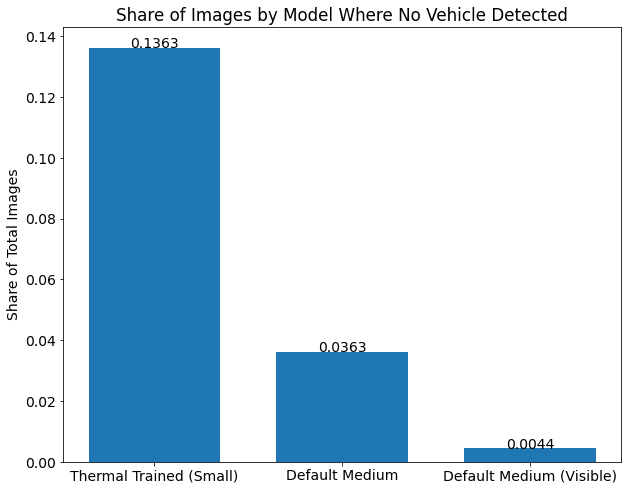

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.set_facecolor('white')
width = 0.7
ax.bar(labels1, no_vehicle, width)

addlabels(labels1, [round(i, 4) for i in no_vehicle])
plt.title('Share of Images by Model Where No Vehicle Detected')
plt.ylabel('Share of Total Images')
plt.show()

# Classification performance

#### Note - classification performance is only measured among images **with a YOLOv5 bounding box** and whose **bounding box confidence >= 0.5**

In [6]:
med_thermal_classes = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-01-11h56_med_therm/logs/predicted_classes.csv'
med_visible_classes = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-01-11h53_med_vis/logs/predicted_classes.csv'
sm_thermal_classes = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-14-16h42/logs/predicted_classes.csv'
med_thermal_sharp_classes = '/Users/josephking/Documents/sponsored_projects/MERGEN/scripts/output/2021-12-10-14h08/logs/predicted_classes.csv'

In [7]:
argmax0 = []
argmax4 = []

for x in [sm_thermal_classes, med_thermal_classes, med_thermal_sharp_classes, med_visible_classes]:
    
    temp = pd.read_csv(x, usecols=['true_label', 'Argmax(0)', 'Argmax(1)', 'Argmax(2)', 'Argmax(3)', 'Argmax(4)'])
    
    true = temp['true_label']
    del temp['true_label']
    
    # Calculate cumulative accuracy
    accuracy = temp.apply(lambda x: true == x)
    accuracy = accuracy.mean().cumsum()
    
    argmax0.append(accuracy.tolist()[0])
    argmax4.append(accuracy.tolist()[4])

argmax4_orig = [round(i, 4) for i in argmax4]
argmax0_rounded = [round(i, 4) for i in argmax0]

# Adjust argmax4 by argmax0 amount
argmax4 = [i - j for i, j in zip(argmax4, argmax0)]

labels2 = ['Thermal Trained (Small)', 'Default Medium', 'Default Medium (Sharp)', 'Default Medium (Visible)']

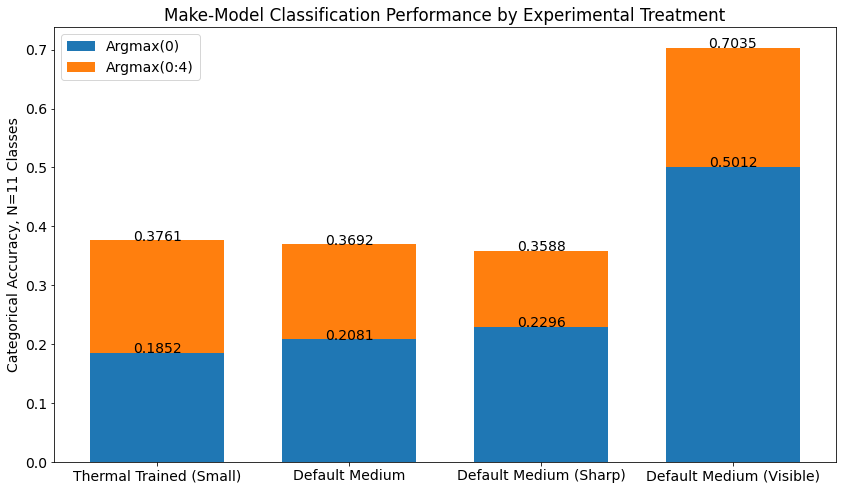

In [8]:
fig, ax = plt.subplots(figsize=(14, 8))
fig.set_facecolor('white')
width = 0.7
ax.bar(labels2, argmax0, width, label='Argmax(0)')
ax.bar(labels2, argmax4, width, bottom=argmax0, label='Argmax(0:4)')
addlabels(labels2, argmax4_orig)
addlabels(labels2, argmax0_rounded)
plt.title('Make-Model Classification Performance by Experimental Treatment')
plt.ylabel('Categorical Accuracy, N=11 Classes')
plt.legend()
plt.show()

### Adjusting for images where no vehicle detected

In [9]:
# Values for plots
argmax0_adj = argmax0[:2] + [argmax0[-1]]
argmax0_adj = [i * j for i, j in zip(argmax0_adj, [1-i for i in no_vehicle])]
argmax4_adj = argmax4[:2] + [argmax4[-1]]
argmax4_adj = [i * j for i, j in zip(argmax4_adj, [1-i for i in no_vehicle])]

# Original values to display
argmax4_orig_adj = argmax4_orig[:2] + [argmax4_orig[-1]]
argmax4_orig_adj = [i * j for i, j in zip(argmax4_orig_adj, [1-i for i in no_vehicle])]
argmax4_orig_adj = [round(i, 4) for i in argmax4_orig_adj]
argmax0_rounded_adj = argmax0[:2] + [argmax0[-1]]
argmax0_rounded_adj = [i * j for i, j in zip(argmax0_rounded_adj, [1-i for i in no_vehicle])]
argmax0_rounded_adj = [round(i, 4) for i in argmax0_rounded_adj]

labels3 = ['Thermal Trained (Small)', 'Default Medium', 'Default Medium (Visible)']

In [10]:
argmax4_orig_adj

[0.3249, 0.3558, 0.7004]

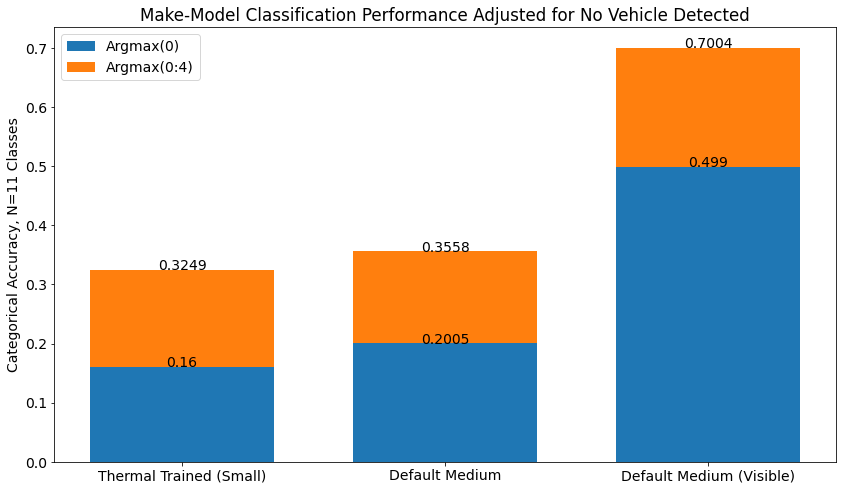

In [11]:
fig, ax = plt.subplots(figsize=(14, 8))
fig.set_facecolor('white')
width = 0.7
ax.bar(labels3, argmax0_adj, width, label='Argmax(0)')
ax.bar(labels3, argmax4_adj, width, bottom=argmax0_adj, label='Argmax(0:4)')
addlabels(labels3, argmax4_orig_adj)
addlabels(labels3, argmax0_rounded_adj)
plt.title('Make-Model Classification Performance Adjusted for No Vehicle Detected')
plt.ylabel('Categorical Accuracy, N=11 Classes')
plt.legend()
plt.show()

# Distribution of confidence by YOLOv5 model

In [12]:
sm_therm_nomiss = sm_therm.loc[sm_therm.Bboxes.str.len() != 0].reset_index(drop=True)
sm_therm_nomiss['conf'] = sm_therm_nomiss['Bboxes'].apply(lambda x: x[-1])

med_therm_nomiss = med_therm.loc[med_therm.Bboxes.str.len() != 0].reset_index(drop=True)
med_therm_nomiss['conf'] = med_therm_nomiss['Bboxes'].apply(lambda x: x[-1])

In [13]:
print(sm_therm_nomiss['conf'].describe())
print('\n')
print(med_therm_nomiss['conf'].describe())

count    1572.000000
mean        0.989380
std         0.044144
min         0.264404
25%         0.994141
50%         0.997070
75%         0.998047
max         1.000000
Name: conf, dtype: float64


count    1754.000000
mean        0.699973
std         0.160959
min         0.250908
25%         0.590939
50%         0.730401
75%         0.832646
max         0.938208
Name: conf, dtype: float64


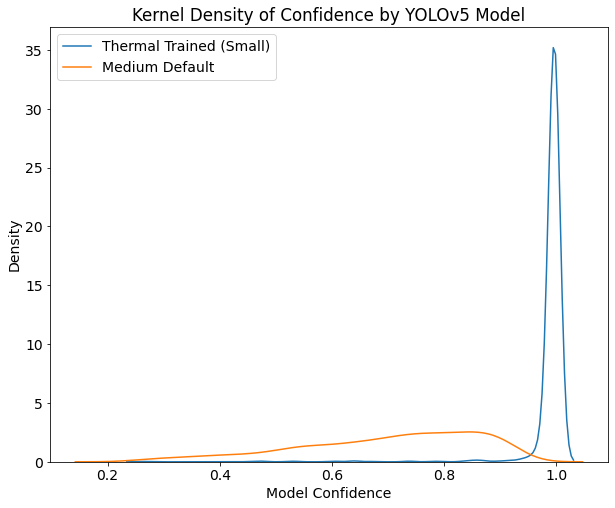

In [14]:
figure(figsize=(10, 8))
sns.kdeplot(sm_therm_nomiss['conf'], label='Thermal Trained (Small)')
sns.kdeplot(med_therm_nomiss['conf'], label='Medium Default')
plt.xlabel('Model Confidence')
plt.title('Kernel Density of Confidence by YOLOv5 Model')
plt.legend()
plt.show()